In [2]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.0 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.3-cp310-cp310-linux_x86_64.whl size=293152 sha256=e57406dd3ab8ec0323f38bcf93f7adf1333fe5cbb8efe597330a7ac611d919e2
  Stored in directory: /root/.cache/pip/wheels/0d/32/b7/cad9f818b37cf97df4c87a8308da86a433af81651d98f8d8aa
Successfully built peewee


In [3]:
# Create a directory if it is not there, so we can save files and results in it
from pathlib import Path
Path('/kaggle/working/lstm2d').mkdir(parents=True,exist_ok=True)

In [4]:
import numpy as np
import pandas as pd
import math
import os
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import yfinance as yf
import tensorflow as tf

In [13]:
def stock_predict_2D(stock_name, filename):

    # Downloading stock data from Yahoo Finance
    stock_data = yf.download(stock_name, start='2019-01-01', end='2024-01-01')
    specific_df = pd.DataFrame(stock_data).reset_index()
    specific_df['Name'] = stock_name

    new_df = specific_df.reset_index()['Close']

    scaler=MinMaxScaler()
    scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

    from sklearn.model_selection import train_test_split
    test_size = 0.2
    train_data, test_data = train_test_split(scaled_data, test_size=test_size, shuffle=False)

    def generate_sequences_and_labels(data, n_past):
        sequences = [data[i - n_past:i, 0] for i in range(n_past, len(data))]
        labels = [data[i, 0] for i in range(n_past, len(data))]
        return np.array(sequences), np.array(labels)

    n_past = 60
    x_train, y_train = generate_sequences_and_labels(train_data, n_past)
    x_test, y_test = generate_sequences_and_labels(test_data, n_past)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)

    ################################### START ##########################################

    def build_lstm_model(input_shape):
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=[x_train.shape[1], 1]))
        model.add(Dense(10))
        model.add(LSTM(units=25))
        # model.add(Dense(5))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        return model

    def compile_lstm_model(model):
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    def train_lstm_model(model, x_train, y_train, x_test, y_test):
        model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=32, verbose=0)

    model = build_lstm_model(x_train.shape[1])
    compile_lstm_model(model)
    train_lstm_model(model, x_train, y_train, x_test, y_test)

    ######################################## END #######################################

    folder_path = "/kaggle/working/lstm2d/"  # Get the current script's directory
    filename_a = folder_path+filename+'_lstm2d.keras'
    model.save(filename_a)
    
#     # folder_path = os.path.dirname(os.path.abspath(__file__))  # Get the current script's directory
#     filename_a = filename + "2D.keras"
#     # model.save(filename_a)

#     model = tf.keras.models.load_model(filename_a)

    def make_predictions(model, x_train, x_test):
        train_predict = model.predict(x_train)
        test_predict = model.predict(x_test)
        return train_predict, test_predict

    train_predict, test_predict = make_predictions(model, x_train, x_test)


    def inverse_transform(scaler, y_train, train_predict, y_test, test_predict):
        y_test = y_test.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        y_test = scaler.inverse_transform(y_test)
        y_train = scaler.inverse_transform(y_train)
        train_predict = scaler.inverse_transform(train_predict)
        test_predict = scaler.inverse_transform(test_predict)
        return y_test, y_train, train_predict, test_predict


    y_test, y_train, train_predict, test_predict = inverse_transform(scaler, y_train, train_predict, y_test, test_predict)


    def evaluate_model(y_train, train_predict, y_test, test_predict):
        # train_mse = mean_squared_error(y_train, train_predict)
        test_mse = mean_squared_error(y_test, test_predict)
        test_mae = mean_absolute_error(y_test, test_predict)
        test_mape = mean_absolute_percentage_error(y_test, test_predict)
        test_rs = r2_score(y_test, test_predict)
        # print(f"Training MSE: {train_mse}")
        print(f"MSE of {stock_name}: {test_mse}")
        print(f"MAE of {stock_name}: {test_mae}")
        print(f"MAPE of {stock_name}: {test_mape}")
        print(f"R Sqaured of {stock_name}: {test_rs}")

    evaluate_model(y_train, train_predict, y_test, test_predict)

    predictions = model.predict(x_test)
    actual_values_inverse = y_test

    predicted_values_inverse = scaler.inverse_transform(predictions)

    # comparison_df = pd.DataFrame({'Actual Close Prices': actual_values_inverse.flatten(), 'Predicted Close Prices': predicted_values_inverse.flatten()})
    # print(comparison_df.head())

    # plt.figure(figsize=(10, 5))
    # plt.plot(actual_values_inverse.flatten(), label="Actual Close Prices")
    # plt.plot(predicted_values_inverse.flatten(), 'r', label="Predicted Close Prices")
    # plt.ylabel('Close Price')
    # plt.xlabel('Time Step')
    # plt.legend()
    # plt.title(stock_name+'-LSTM 2D')
    # #plt.show()

    # plt_name = os.path.join(folder_path, f"{stock_name}2D.png")
    # plt.savefig(plt_name)
    
    plt.figure(figsize=(10, 5))
    plt.plot(actual_values_inverse.flatten(), label="Actual Close Prices")
    plt.plot(predicted_values_inverse.flatten(), 'r', label="Predicted Close Prices")
    plt.ylabel('Close Price')
    plt.xlabel('Time Step')
    plt.legend()
    plt.title(stock_name+'-LSTM 2D')
    plt_name = folder_path+filename+'_lstm2d.png'
    plt.savefig(plt_name)

In [14]:
stock_list = ["AAPL","AMGN","AXP","BA","CAT","CRM","CSCO","CVX","DIS","DOW","GS","HD","HON",
              "IBM","INTC","JNJ","JPM","KO","MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH",
              "V","VZ","WBA","WMT"]
print(len(stock_list))

30


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of AAPL: 14.125912148438756
MAE of AAPL: 3.2990732987721763
MAPE of AAPL: 0.01816220430597597
R Sqaured of AAPL: 0.8568374729813519
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of AMGN: 16.803555026137477
MAE of AMGN: 3.089744965235392
MAPE of AMGN: 0.012061147675632747
R Sqaured of AMGN: 0.9593995916422947
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of AXP: 5.204027535729742
MAE of AXP: 1.7382018566131594
MAPE of AXP: 0.010766428778993226
R Sqaured of AXP: 0.9494118256411068
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of BA: 26.294844146346204
MAE of BA: 4.222222089767456
MAPE of BA: 0.019744026285526895
R Sqaured of BA: 0.9291737083349474
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of CAT: 22.139105840303582
MAE of CAT: 3.437092701594036
MAPE of CAT: 0.013671529592680759
R Sqaured of CAT: 0.965154077042251
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of CRM: 13.910001017611656
MAE of CRM: 2.7881266276041665
MAPE of CRM: 0.012865064627368373
R Sqaured of CRM: 0.9576455459842615
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of CSCO: 0.43915048381472843
MAE of CSCO: 0.43797439336776733
MAPE of CSCO: 0.008574403414047277
R Sqaured of CSCO: 0.9443638683707937
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of CVX: 12.03743276304643
MAE of CVX: 2.9768993059794107
MAPE of CVX: 0.018748711976310433
R Sqaured of CVX: 0.8216868934120926
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of DIS: 4.374270833471807
MAE of DIS: 1.6836402018864949
MAPE of DIS: 0.019047793450790346
R Sqaured of DIS: 0.8779713581592566
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of DOW: 0.527914265156384
MAE of DOW: 0.5593816430529186
MAPE of DOW: 0.010698037444053147
R Sqaured of DOW: 0.8819194075832665
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of GS: 28.32536153213975
MAE of GS: 4.0966800053914385
MAPE of GS: 0.012265047285781932
R Sqaured of GS: 0.9158624565491472
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of HD: 26.431184399140573
MAE of HD: 4.230891704559326
MAPE of HD: 0.013670881354596964
R Sqaured of HD: 0.9229558113858334
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of HON: 4.3934275920946675
MAE of HON: 1.5794238249460857
MAPE of HON: 0.008153512329690464
R Sqaured of HON: 0.9290621712715441
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of IBM: 5.463432885090087
MAE of IBM: 1.9560394684473668
MAPE of IBM: 0.013575780120688385
R Sqaured of IBM: 0.956152929805872
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of INTC: 0.9867312858615187
MAE of INTC: 0.7630121012528738
MAPE of INTC: 0.02189292414830325
R Sqaured of INTC: 0.959582176039995
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of JNJ: 3.7816383422565796
MAE of JNJ: 1.3964365323384607
MAPE of JNJ: 0.008731512015682532
R Sqaured of JNJ: 0.9099143144769519
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of JPM: 4.852274046822761
MAE of JPM: 1.7345717748006184
MAPE of JPM: 0.011739387541546638
R Sqaured of JPM: 0.9437036016757787
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of KO: 0.23296131655797614
MAE of KO: 0.36525019009908094
MAPE of KO: 0.006176085938818905
R Sqaured of KO: 0.9705361034688842
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of MCD: 5.4030715613625935
MAE of MCD: 1.7912890116373699
MAPE of MCD: 0.006397561378891713
R Sqaured of MCD: 0.9682033857885771
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of MMM: 5.681289186108188
MAE of MMM: 2.050860563913981
MAPE of MMM: 0.02486792444368478
R Sqaured of MMM: 0.7673893957186433
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of MRK: 2.2018952282263253
MAE of MRK: 1.1727559566497805
MAPE of MRK: 0.010827243544890784
R Sqaured of MRK: 0.8953846276068891
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/tmp/ipykernel_34/1005419201.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))
[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of MSFT: 40.625126323682075
MAE of MSFT: 5.16710821787516
MAPE of MSFT: 0.015402554185131374
R Sqaured of MSFT: 0.9385599610643068
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of NKE: 4.724518067436292
MAE of NKE: 1.5876283645629876
MAPE of NKE: 0.01447447414039397
R Sqaured of NKE: 0.9464699945350553
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of PG: 2.039856877707887
MAE of PG: 1.0750116507212326
MAPE of PG: 0.007149219626091223
R Sqaured of PG: 0.8576385760044034
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of TRV: 4.525043072039504
MAE of TRV: 1.6348725159962971
MAPE of TRV: 0.009487653005365365
R Sqaured of TRV: 0.918527987669714
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of UNH: 42.80790979456406
MAE of UNH: 4.620962619781494
MAPE of UNH: 0.009243436104791164
R Sqaured of UNH: 0.9283971647498965
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of V: 9.88963071127486
MAE of V: 2.680758873621624
MAPE of V: 0.011181206708901804
R Sqaured of V: 0.9036488945181971
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of VZ: 0.6614211073691082
MAE of VZ: 0.6494613786538442
MAPE of VZ: 0.018720390285598427
R Sqaured of VZ: 0.8735789578173541
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of WBA: 2.6851654654829713
MAE of WBA: 1.4829623500506084
MAPE of WBA: 0.05878315603260903
R Sqaured of WBA: 0.8929009196707782
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE of WMT: 0.49859458179366795
MAE of WMT: 0.5201416611671446
MAPE of WMT: 0.009913054651125614
R Sqaured of WMT: 0.8418331126017953
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


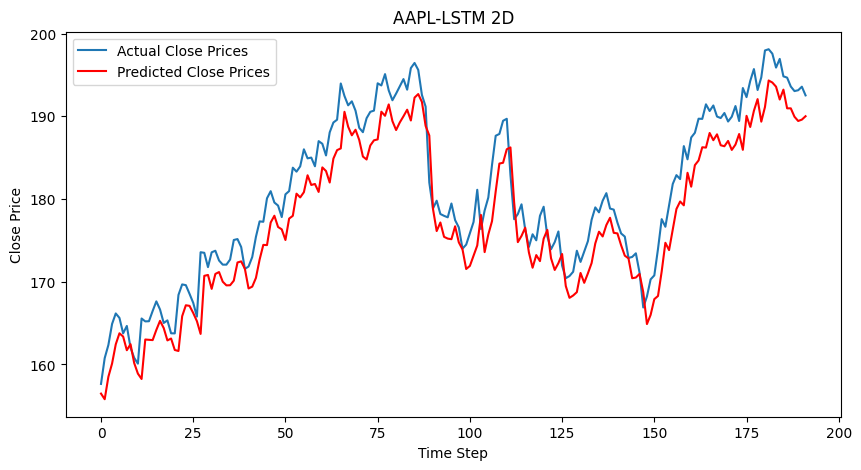

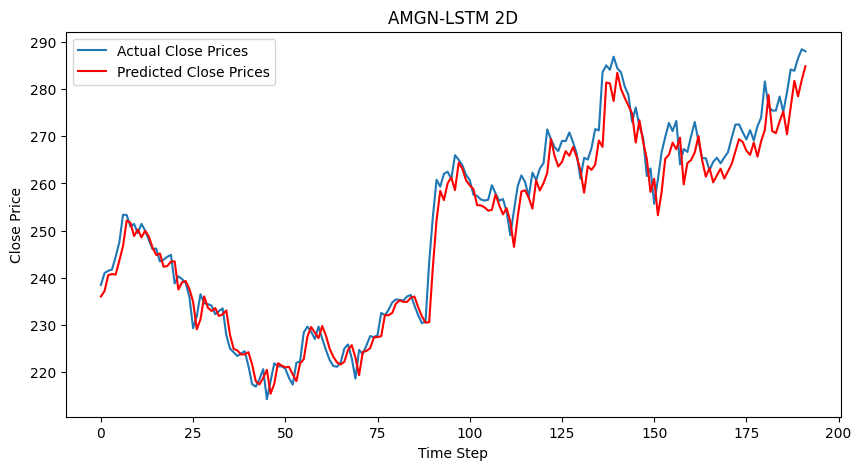

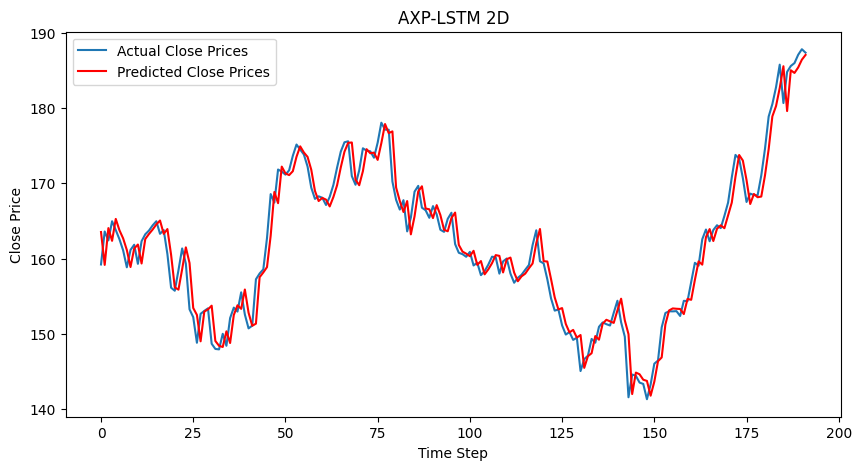

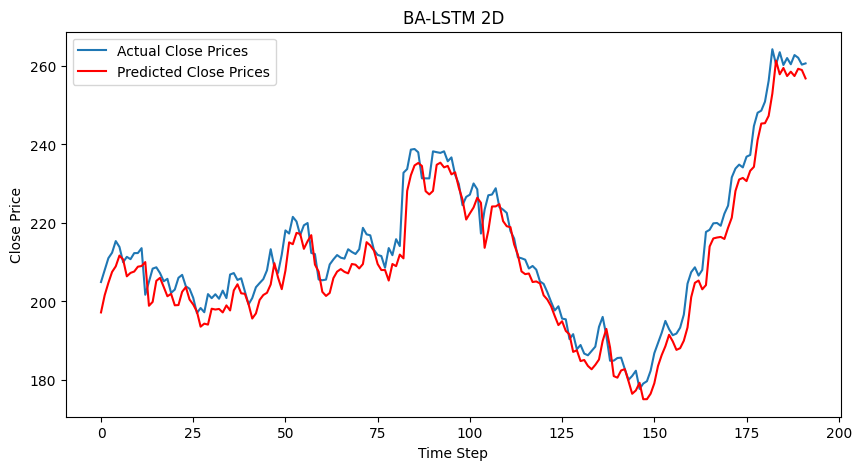

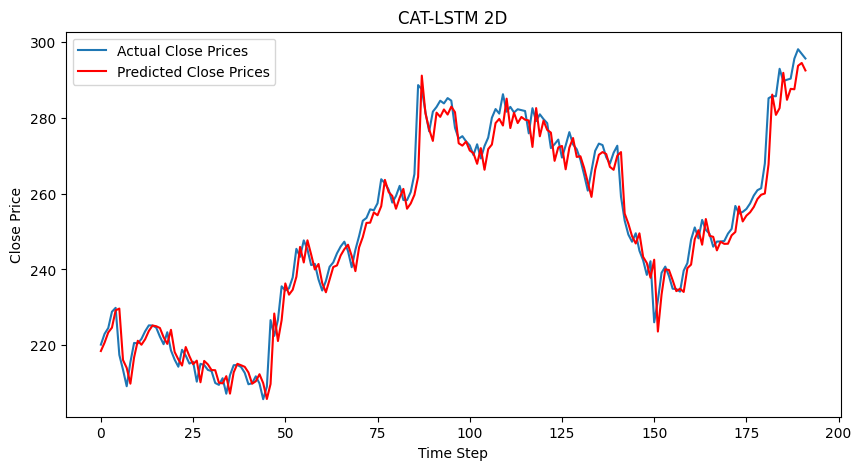

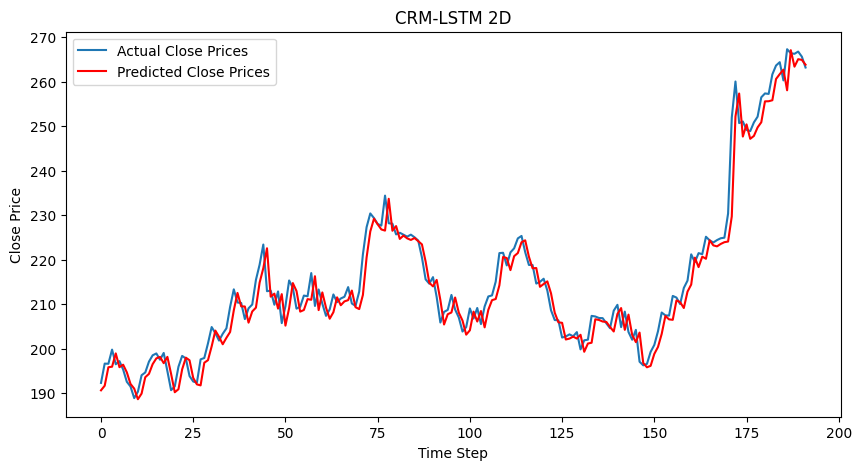

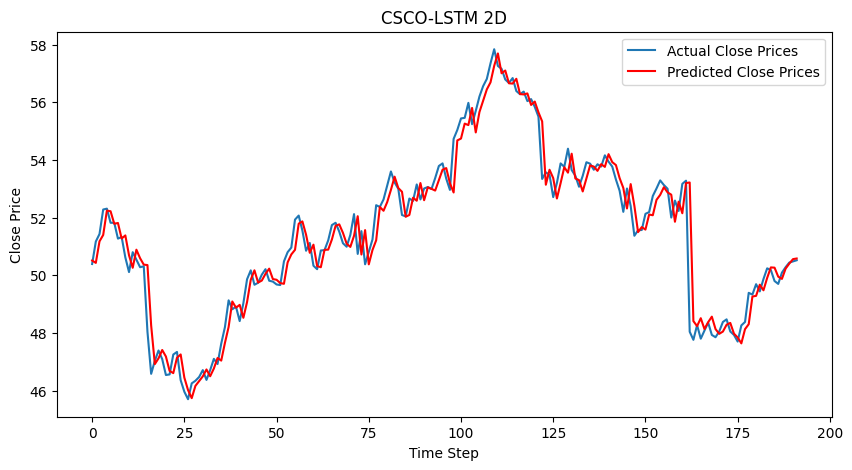

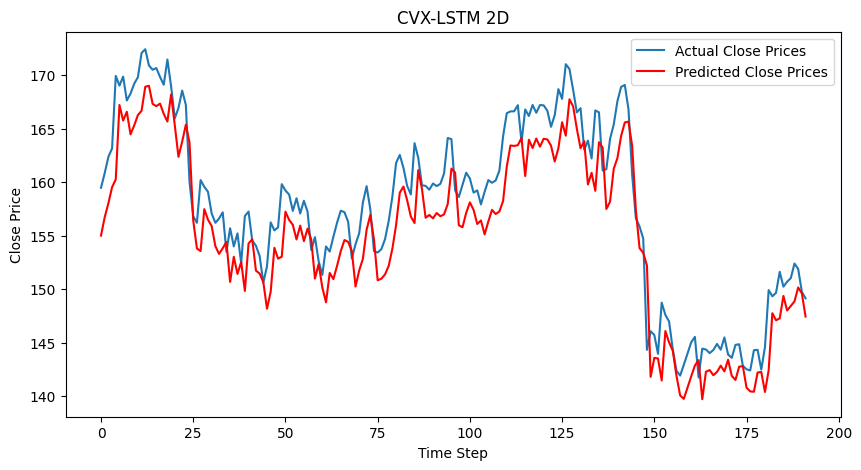

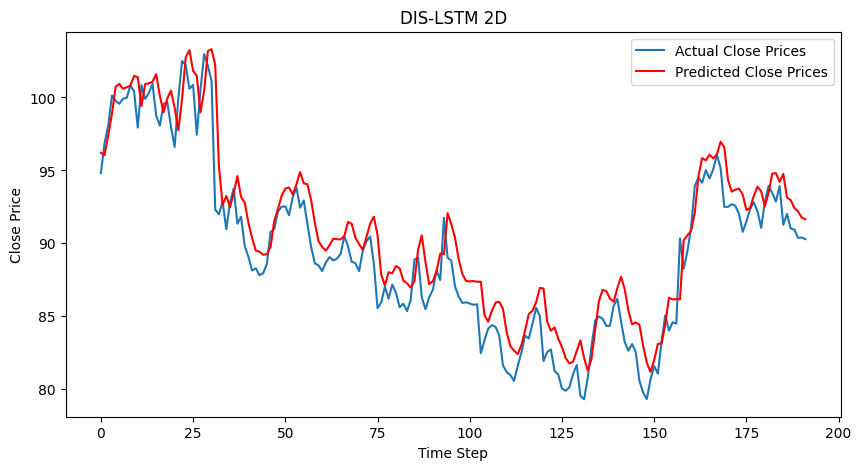

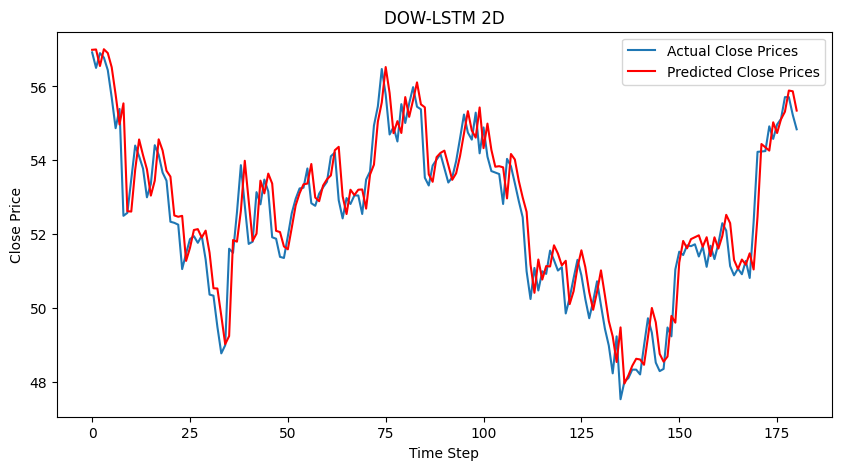

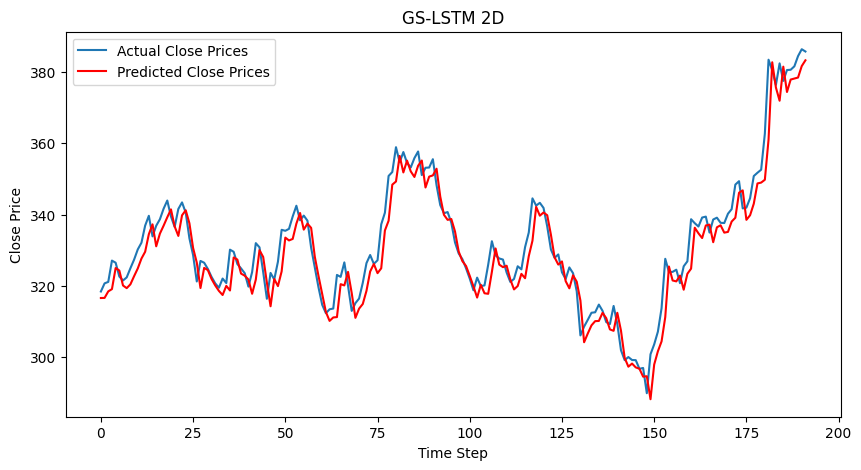

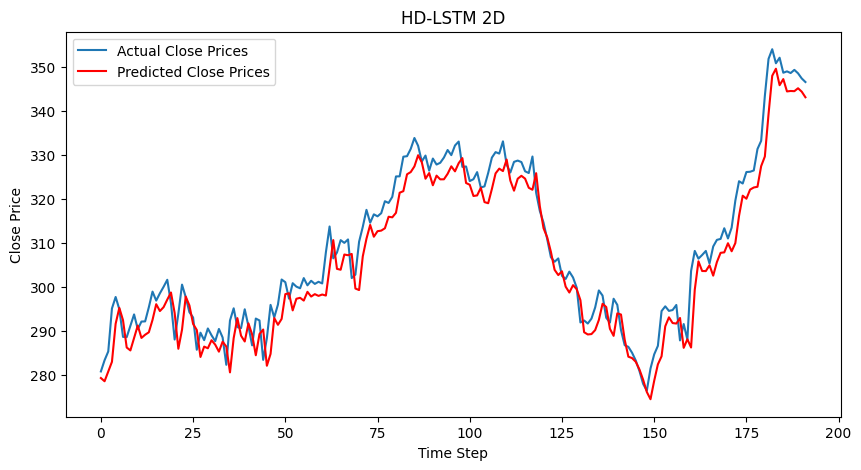

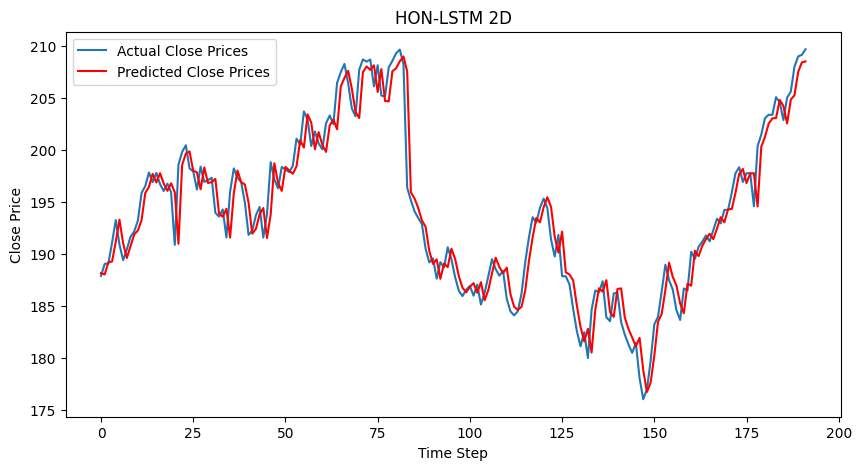

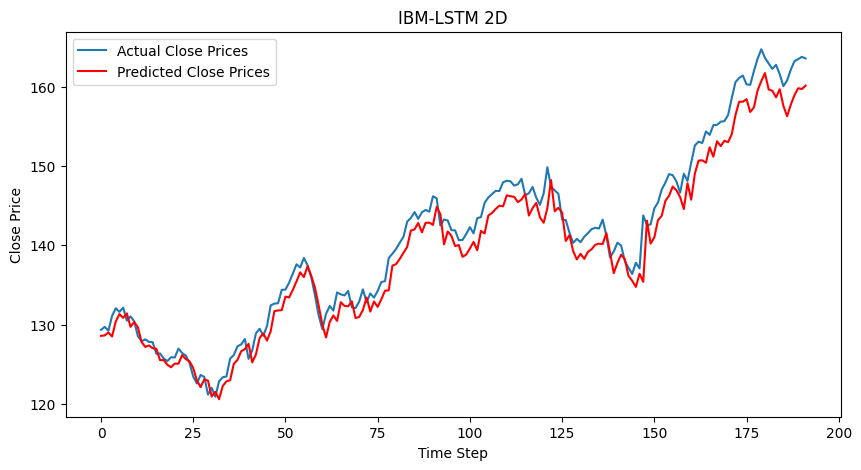

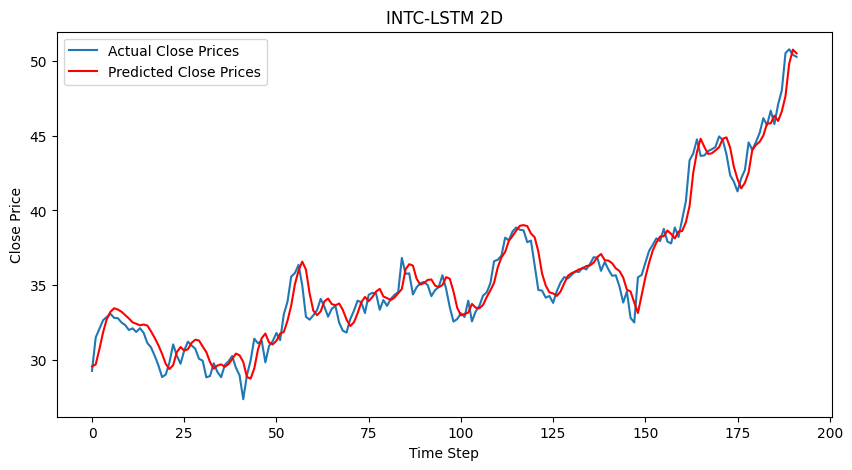

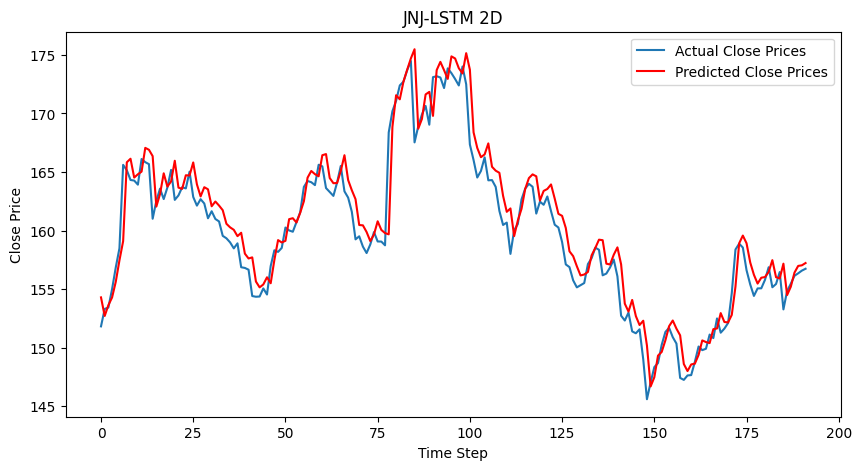

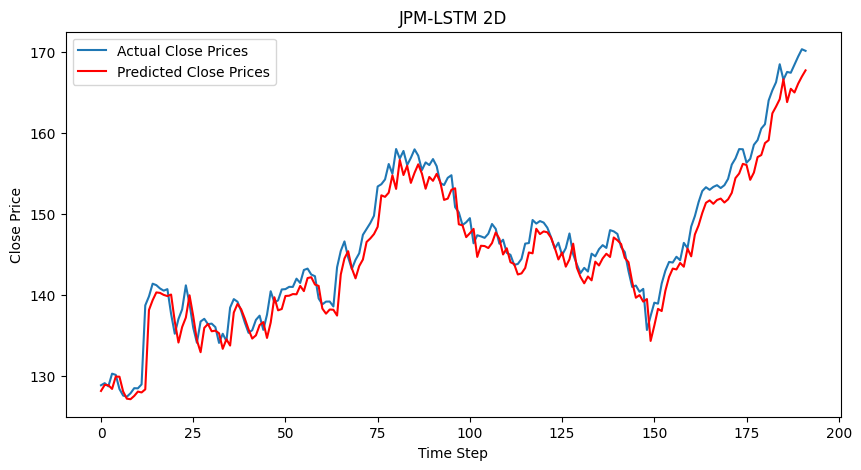

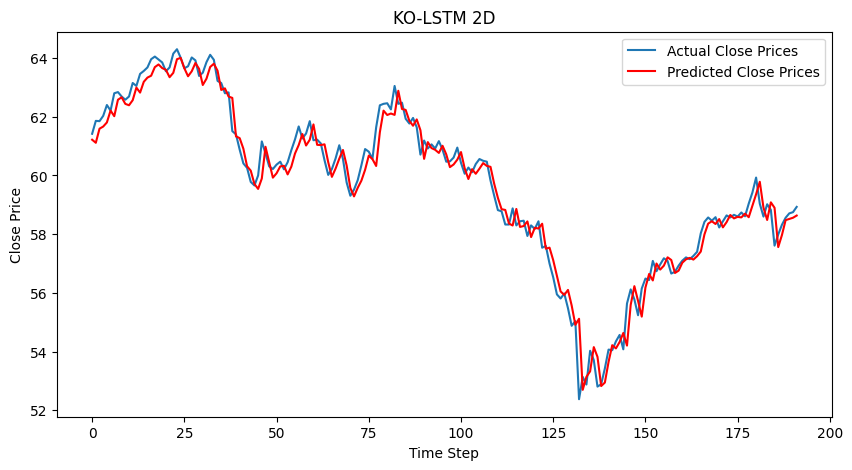

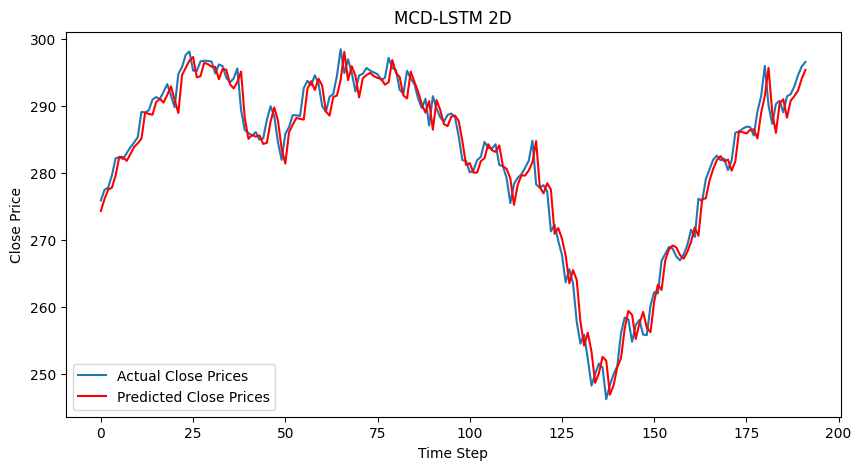

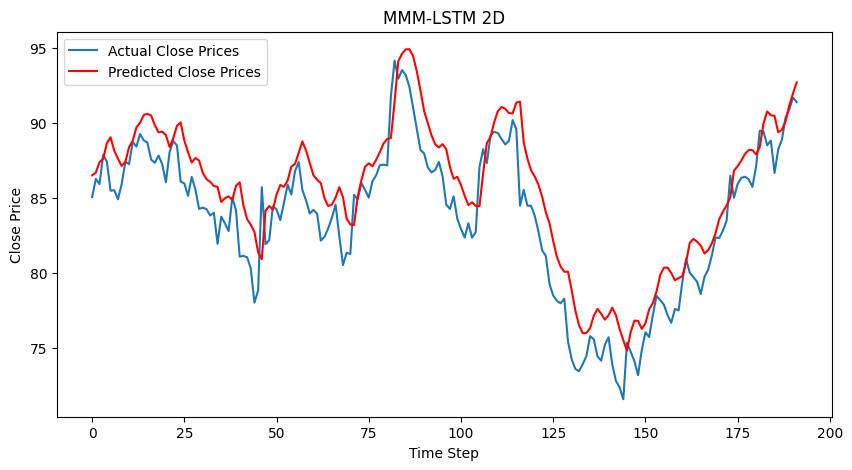

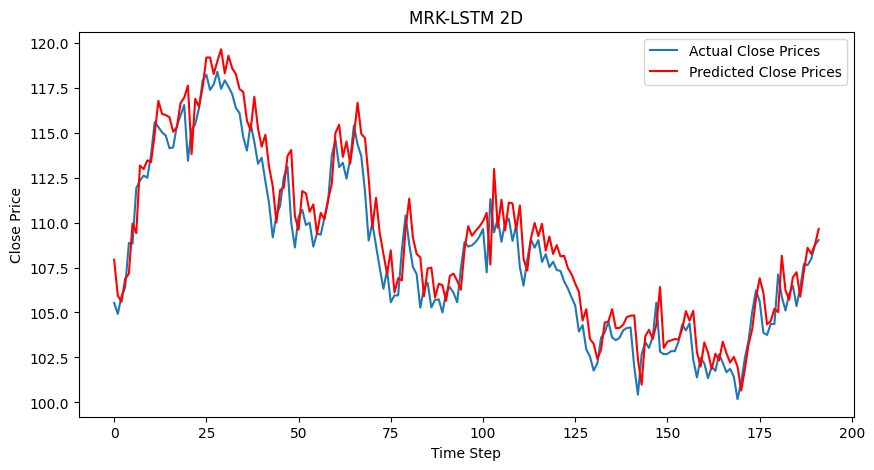

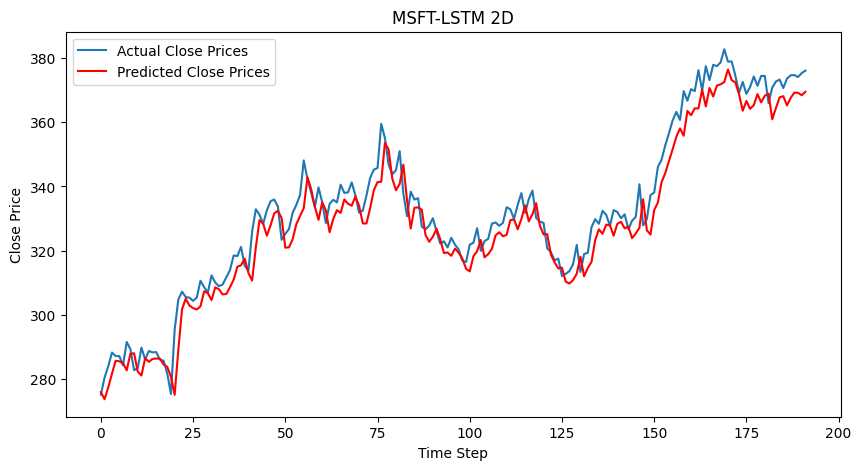

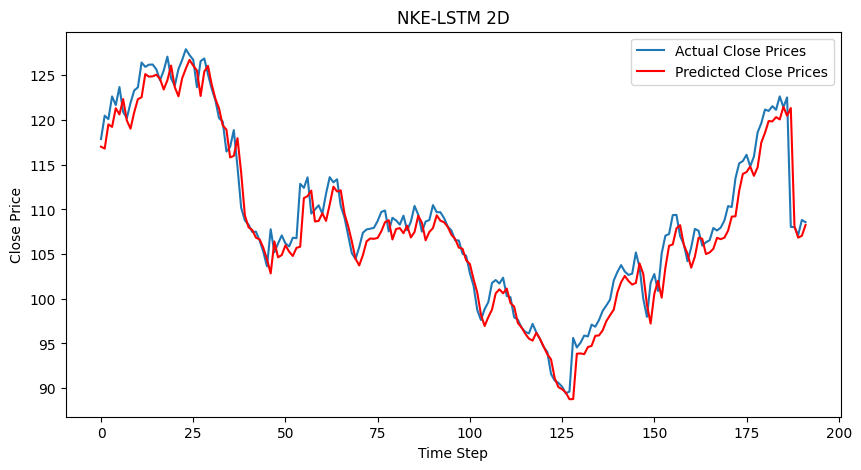

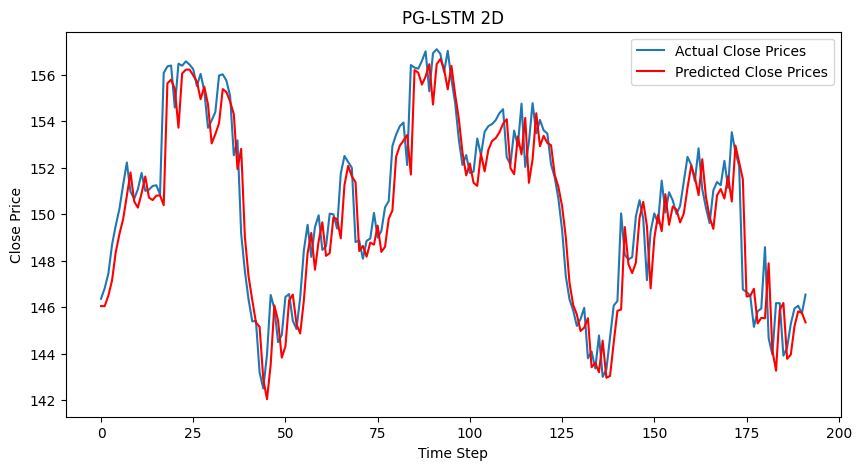

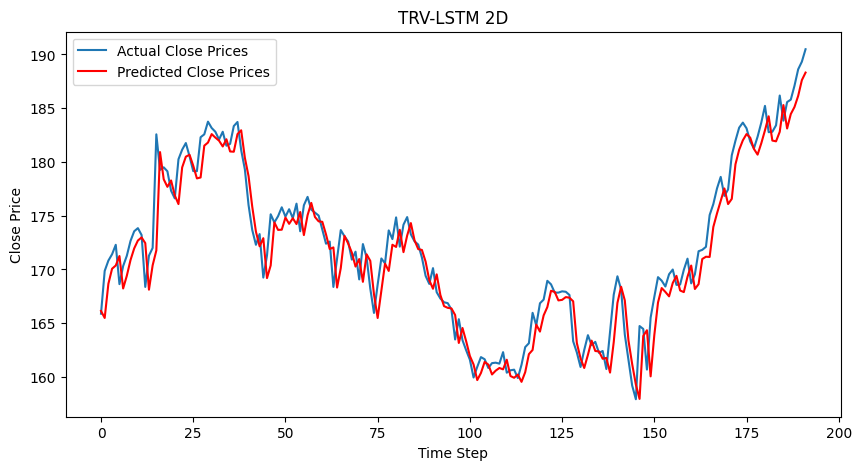

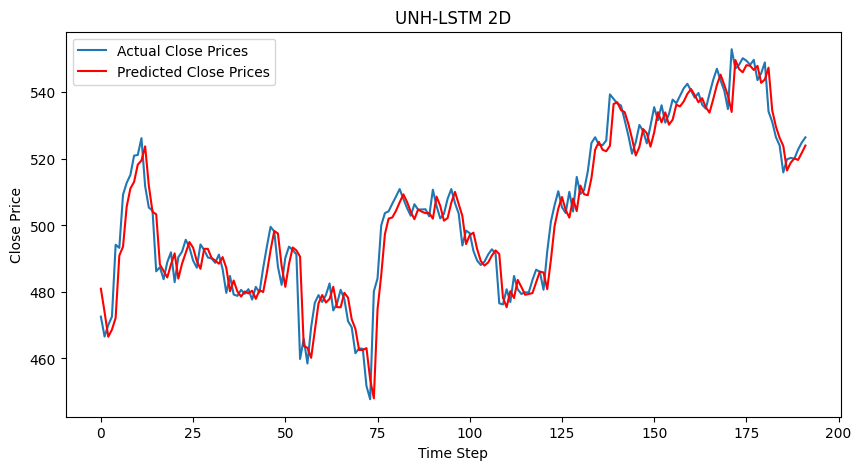

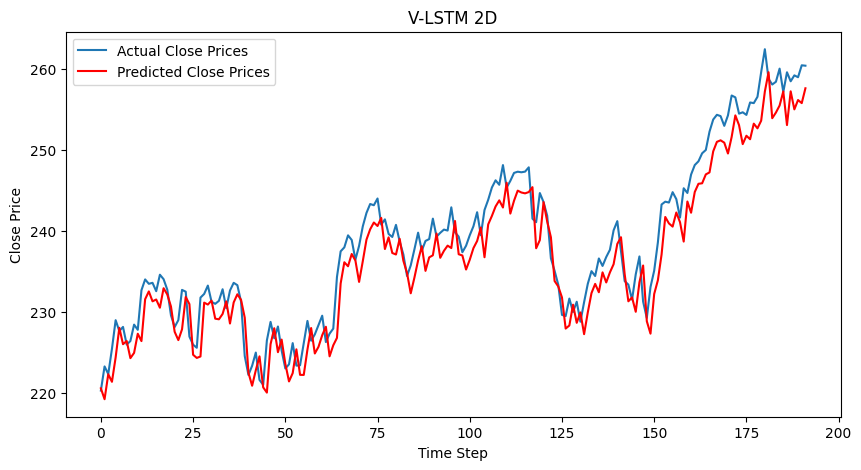

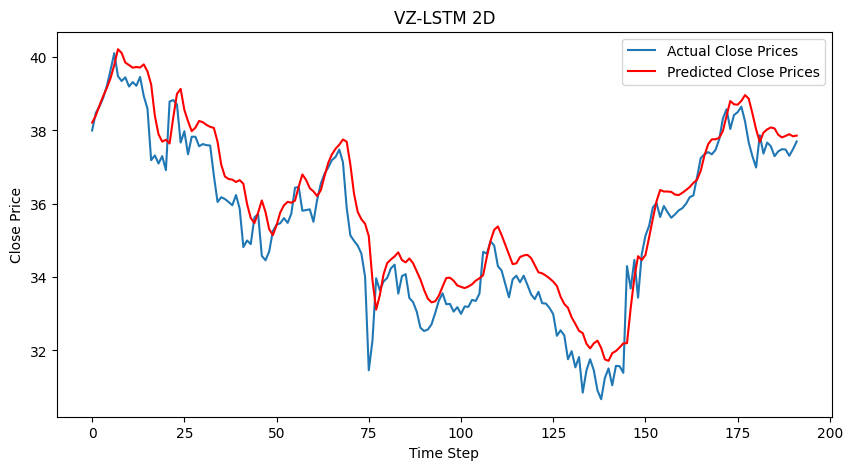

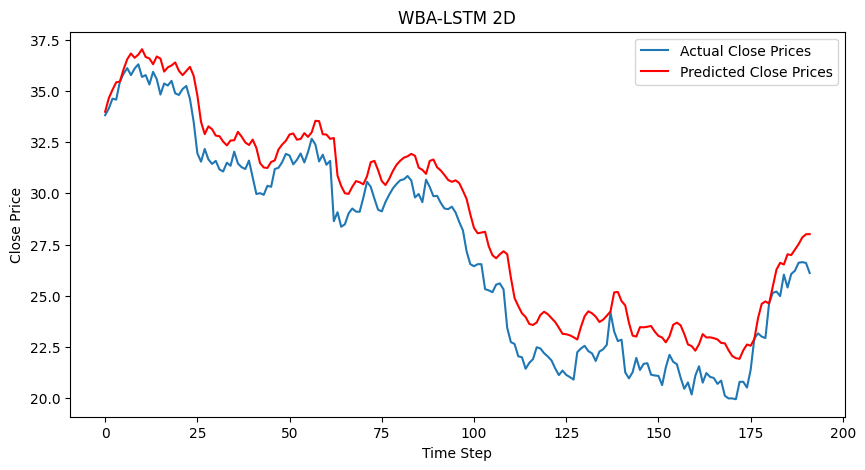

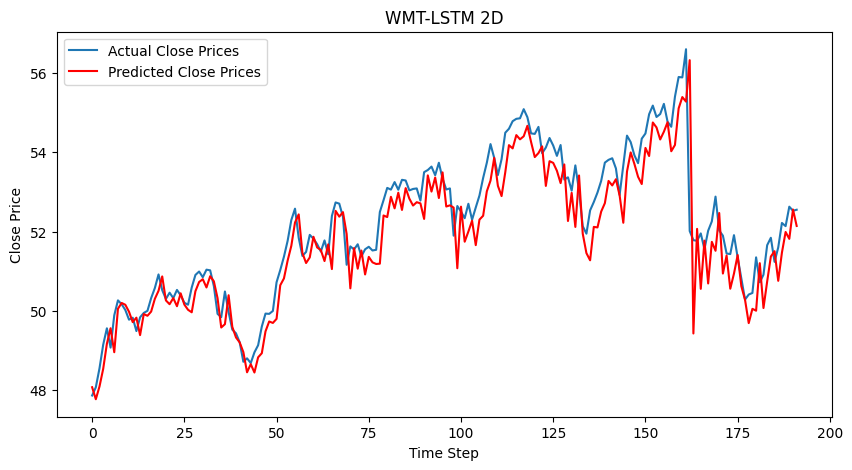

In [15]:
for stock in stock_list:
    stock_predict_2D(stock,stock)

In [16]:
!cd /kaggle/working
!zip -r lstm2d.zip /kaggle/working/lstm2d

  adding: kaggle/working/lstm2d/ (stored 0%)
  adding: kaggle/working/lstm2d/DOW_lstm2d.keras (deflated 18%)
  adding: kaggle/working/lstm2d/JPM_lstm2d.keras (deflated 19%)
  adding: kaggle/working/lstm2d/CRM_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm2d/JNJ_lstm2d.keras (deflated 18%)
  adding: kaggle/working/lstm2d/CSCO_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm2d/MCD_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm2d/NKE_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm2d/GS_lstm2d.keras (deflated 18%)
  adding: kaggle/working/lstm2d/MCD_lstm2d.keras (deflated 18%)
  adding: kaggle/working/lstm2d/IBM_lstm2d.keras (deflated 19%)
  adding: kaggle/working/lstm2d/KO_lstm2d.keras (deflated 18%)
  adding: kaggle/working/lstm2d/V_lstm2d.png (deflated 4%)
  adding: kaggle/working/lstm2d/JPM_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm2d/AXP_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm2d/CAT_lstm2d.keras (deflated 18%)
  adding: kaggle/wo